In [12]:
source('src/lib.r')
source('src/titanic/titanic_dataset.R')

### The Bias - Variance Trade Off

In the previous notebook, we have seen different ML models...how do we evaluate which model is the best for our dataset? To answer this question we need to measure the models performances with some sort of objective function. 

Here we focus on one objective function called **Accuracy** that is simple defined as:

$$\frac{\textrm{number of right predictions}}{\textrm{total number of predictions}}$$

In the following notebook we'll see when the **Accuracy** is not the right measure to use and which are the alternative ones.

For now, in this notebook, we start to focus on the **final aim** of a machine learning model...

As you can remember from the first presentation, the final aim of a ML models is **the prediction on new data**, not the performance on the current one. As a consequence we're interested in the **Accuracy** on the new data not on the original one. How to achieve this goal? Put aside some observations of the original dataset and use them to assess the final model performance.

Let's put this in a more formal setting: let's say we have trained our model $f: X \rightarrow Y$ on the so-called training observations:

$$\textrm{training set:} \left\{ (x_1,y_1), (x_2,y_2), \dots, (x_n,y_n) \right\}$$

We're no really interested int the *training set* accuracy (or any other measure previously shown):

$$\textrm{training accuracy:} \frac{1}{n} \sum_{i = 1}^n \mathbb{I}(f(x_i) = y_i)$$

But given a set of new observations, **not used to train the model**:

$$\textrm{test set:} \left\{ (\tilde{x}_1,\tilde{y}_1), (\tilde{x}_2,\tilde{y}_2), \dots, (\tilde{x}_k,\tilde{y}_k) \right\}$$

We are interest in the *test set* accuracy:

$$\textrm{test accuracy:} \frac{1}{n} \sum_{i = 1}^k \mathbb{I}(f(\tilde{x}_i) = \tilde{y}_i)$$

To better explain these concepts, the titanic dataset has been already partitioned in *training* and *test* set:

In [19]:
titanic_df <- get_titanic_df()
titanic_df$x_train %>% head
titanic_df$y_train %>% head
titanic_df$x_test %>% head
titanic_df$y_test %>% head

pclass,sex,age,sibsp,parch,fare,cabin,embarked
1,1,29.0000,0,0,211.3375,36,3
1,2,0.9167,1,2,151.5500,64,3
1,2,48.0000,0,0,26.5500,120,3
1,2,39.0000,0,0,0.0000,13,3
1,1,24.0000,0,0,69.3000,27,1
1,1,26.0000,0,0,78.8500,149,3


class
Yes
Yes
Yes
Not
Yes
Yes


pclass,sex,age,sibsp,parch,fare,cabin,embarked
1,1,2,1,2,151.5500,33,3
1,2,30,1,2,151.5500,33,3
1,1,25,1,2,151.5500,33,3
1,1,63,1,0,77.9583,59,3
1,1,53,2,0,51.4792,24,3
1,2,71,0,0,49.5042,75,1


class
Not
Not
Not
Yes
Yes
Not


Let's train a simple *KNN* model on the train set (3 neighbors, rectangular kernel and euclidean distance):

In [63]:
model <-  train(
    y = titanic_df$y_train$class,
    x = titanic_df$x_train,
    method = "kknn",
    ks = 3,
    trControl = trainControl(classProbs =  TRUE, method = "none"),
    tuneGrid = data.frame(
          kmax = 1,
          distance = 2,
          kernel = 'rectangular'
      )
)

Let's compute the *training set* accuracy

In [64]:
predictions <- predict(model, titanic_df$x_train)
confusionMatrix(predictions, titanic_df$y_train$class)$overall["Accuracy"]

Accuracy 
0.8594771

But what about the *testing set* accuracy?

In [65]:
predictions <- predict(model, titanic_df$x_test)
confusionMatrix(predictions, titanic_df$y_test$class)$overall["Accuracy"]

Accuracy 
0.5892857

Ooops...not a great result eh!

What's going on? Let's try different numbers of neighbors and analyze the variation in Accuracy

In [66]:
accuracy_df <- data_frame()
for(k in 1:50) {
    model <-  train(
    y = titanic_df$y_train$class,
    x = titanic_df$x_train,
    method = "kknn",
    ks = k,
    trControl = trainControl(classProbs =  TRUE, method = "none"),
    tuneGrid = data.frame(
          kmax = 1,
          distance = 2,
          kernel = 'rectangular'
      )
    )
    
    predictions <- predict(model, titanic_df$x_test)
    test_accuracy <- confusionMatrix(predictions, titanic_df$y_test$class)$overall["Accuracy"]
    
    predictions <- predict(model, titanic_df$x_train)
    train_accuracy <- confusionMatrix(predictions, titanic_df$y_train$class)$overall["Accuracy"]
    
    accuracy_df <- rbind(
        accuracy_df,
        data_frame(
            k = k,
            test = test_accuracy,
            train = train_accuracy
        )
    )
}

[1] 21

[1] 1

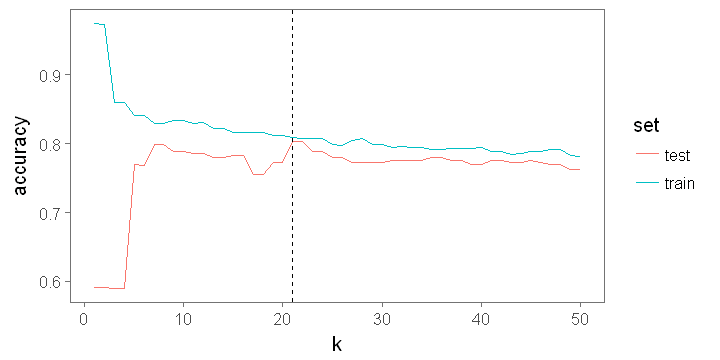

In [67]:
options(repr.plot.width=6, repr.plot.height=3) ### set a small plot size

(best_test_k <- accuracy_df %>% arrange(desc(test)) %>% head(n = 1) %>% pull(k))
(best_train_k <- accuracy_df %>% arrange(desc(train)) %>% head(n = 1) %>% pull(k))
accuracy_df %>% gather(set, accuracy, -k) %>% 
    ggplot(aes(x = k, y = accuracy, color = set)) +
    geom_line() +
    geom_vline(xintercept = best_test_k, lty = 2) +
    theme_few()


So the best number of neighbors for the train set is 1, while the best number for the test set is 21. Why this big difference?
Moreover, why to high accuracy in the *training set* (low *k*) corresponds low accuracy in the *test set*?

This effect is called **the bias - variance tradeoff**. By selecting **lower $k$** we are finding a model that better fits (i.e. with a **lower bias**) the considered *training set*. But in this way, we are also generating a model that highly depends on the particular *training set*, or, in other terms, if we'd fit, multiple times, the *KNN* with the same $k$ but with different *training sets* we'd produce parameters and predictions having a **high variance**: in other words, we are **overfitting** on the *training set*, the obtained model has less generalization capabilities and, a consequence, lower *test set* accuracy.

And so...how to set the right $k$ parameter? We need to find a tradeoff between **bias** and **variance**, in this example this tradeoff seems to be reached for $k =21$.

However, in quest for the right *hyperparameters* values we shouldn't use the *test* set: this test shouldn't be touched until we would like to asses the final performance of our model with the chosen *hyperparameters* values on observations that have not been used neither during the *model fit* procedures nor during the *model selection* phase. During both phase we should leverage only on the *training set*, how? We'll discuss this topic in another notebook.
